**PRELIMINARY NOTEBOOK SETUP**

In [ ]:
# load necessary imports
%pip install google-cloud-bigquery-storage
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

# Load credentials (adjust path as needed)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = '/content/credentials/machine-learning-final-477822.json'

load_dotenv()
load_dotenv()

False

In [ ]:
# define BigQuery client
bq_client = bigquery.Client(project="machine-learning-final-477822")
# query the full ACS census tract table:
query = """
SELECT *
FROM `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
"""

# run query
query_job = bq_client.query(query)

acs_df = query_job.result().to_dataframe(create_bqstorage_client=False)

print("Loaded ACS dataframe with shape:", acs_df.shape)
acs_df.head()

Loaded ACS dataframe with shape: (85395, 245)


,geo_id,aggregate_travel_time_to_work,amerindian_including_hispanic,amerindian_pop,armed_forces,asian_including_hispanic,asian_male_45_54,asian_male_55_64,asian_pop,associates_degree,...,vacant_housing_units,vacant_housing_units_for_rent,vacant_housing_units_for_sale,walked_to_work,white_including_hispanic,white_male_45_54,white_male_55_64,white_pop,worked_at_home,workers_16_and_over
0,1001020200,18595.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,72.0,...,147.0,32.0,0.0,0.0,647.0,89.0,32.0,641.0,10.0,700.0
1,1001020300,47570.0,0.0,0.0,21.0,44.0,0.0,0.0,44.0,243.0,...,113.0,0.0,0.0,34.0,2363.0,143.0,232.0,2363.0,32.0,1959.0
2,1001020400,37660.0,10.0,10.0,10.0,17.0,0.0,0.0,17.0,257.0,...,105.0,23.0,25.0,28.0,3097.0,121.0,258.0,3085.0,45.0,1583.0
3,1001020503,28605.0,0.0,0.0,96.0,18.0,0.0,0.0,18.0,252.0,...,0.0,0.0,0.0,22.0,2397.0,218.0,105.0,2397.0,121.0,1606.0
4,1001020600,23255.0,0.0,0.0,40.0,11.0,0.0,0.0,11.0,145.0,...,134.0,43.0,22.0,6.0,2667.0,193.0,176.0,2551.0,80.0,1212.0


In [ ]:
dp05_cols = [
    "total_pop",
    "male_pop",
    "female_pop",
    "male_under_5",
    "male_5_to_9",
    "male_10_to_14",
    "male_15_to_17",
    "male_18_to_19",
    "male_20",
    "male_21",
    "male_22_to_24",
    "male_25_to_29",
    "male_30_to_34",
    "male_35_to_39",
    "male_40_to_44",
    "male_45_to_49",
    "male_50_to_54",
    "male_55_to_59",
    "male_60_to_61",
    "male_62_to_64",
    "male_65_to_66",
    "male_67_to_69",
    "male_70_to_74",
    "male_75_to_79",
    "male_80_to_84",
    "male_85_and_over",
    "female_under_5",
    "female_5_to_9",
    "female_10_to_14",
    "female_15_to_17",
    "female_18_to_19",
    "female_20",
    "female_21",
    "female_22_to_24",
    "female_25_to_29",
    "female_30_to_34",
    "female_35_to_39",
    "female_40_to_44",
    "female_45_to_49",
    "female_50_to_54",
    "female_55_to_59",
    "female_60_to_61",
    "female_62_to_64",
    "female_65_to_66",
    "female_67_to_69",
    "female_70_to_74",
    "female_75_to_79",
    "female_80_to_84",
    "female_85_and_over",
    "white_pop",
    "black_pop",
    "asian_pop",
    "amerindian_pop",
    "other_race_pop",
    "two_or_more_races_pop",
    "hispanic_pop",
    "white_including_hispanic",
    "black_including_hispanic",
    "asian_including_hispanic",
]
dp05_df = acs_df[["geo_id"] + dp05_cols].copy()
dp05_df.head()


,geo_id,total_pop,male_pop,female_pop,male_under_5,male_5_to_9,male_10_to_14,male_15_to_17,male_18_to_19,male_20,...,white_pop,black_pop,asian_pop,amerindian_pop,other_race_pop,two_or_more_races_pop,hispanic_pop,white_including_hispanic,black_including_hispanic,asian_including_hispanic
0,1001020200,1757.0,1010.0,747.0,81.0,77.0,22.0,52.0,16.0,0.0,...,641.0,1026.0,0.0,0.0,14.0,46.0,30.0,647.0,1026.0,0.0
1,1001020300,3694.0,1839.0,1855.0,58.0,134.0,227.0,74.0,25.0,24.0,...,2363.0,1042.0,44.0,0.0,0.0,65.0,180.0,2363.0,1042.0,44.0
2,1001020400,3539.0,1794.0,1745.0,41.0,80.0,96.0,19.0,14.0,48.0,...,3085.0,309.0,17.0,10.0,0.0,101.0,17.0,3097.0,309.0,17.0
3,1001020503,3268.0,1612.0,1656.0,39.0,89.0,123.0,129.0,8.0,0.0,...,2397.0,659.0,18.0,0.0,0.0,194.0,0.0,2397.0,659.0,18.0
4,1001020600,3536.0,1591.0,1945.0,112.0,206.0,82.0,54.0,40.0,0.0,...,2551.0,716.0,11.0,0.0,25.0,47.0,186.0,2667.0,716.0,11.0


In [ ]:
# Get table dimensions and shape
query = """
SELECT
    COUNT(*) as total_rows
    FROM `bigquery-public-data.census_bureau_acs.cbsa_2020_5yr`
"""
query_job = bq_client.query(query)
results = query_job.result()
for row in results:
    print(f"Total rows: {row.total_rows}")

# Now Filter for Rhode Island
query = """
SELECT
    COUNT(*) as total_rows
    FROM `bigquery-public-data.census_bureau_acs.cbsa_2020_5yr`
    WHERE geo_id LIKE '44%'
"""
query_job = bq_client.query(query)
results = query_job.result()
ri_rent_df_dp05 = results.to_dataframe()

print(f"Total rows: {len(ri_rent_df_dp05)}")
ri_rent_df_dp05.head()

Total rows: 939
Total rows: 1


,total_rows
0,23


**CLEAN DATA**

In [ ]:
# Create target variable 'high_rent_burden'
acs_df['high_rent_burden'] = acs_df['percent_income_spent_on_rent'] >= 30
acs_df['high_rent_burden'].head()

,high_rent_burden
0,True
1,False
2,False
3,False
4,False


In [ ]:
dp05_df.shape
dp05_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85395 entries, 0 to 85394
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   geo_id                    85395 non-null  object 
 1   total_pop                 85395 non-null  float64
 2   male_pop                  85395 non-null  float64
 3   female_pop                85395 non-null  float64
 4   male_under_5              85395 non-null  float64
 5   male_5_to_9               69440 non-null  float64
 6   male_10_to_14             85395 non-null  float64
 7   male_15_to_17             85395 non-null  float64
 8   male_18_to_19             85395 non-null  float64
 9   male_20                   85395 non-null  float64
 10  male_21                   85395 non-null  float64
 11  male_22_to_24             85395 non-null  float64
 12  male_25_to_29             85395 non-null  float64
 13  male_30_to_34             85395 non-null  float64
 14  male_3

In [ ]:
sentinel_values = [-666666666, -777777777, -888888888, -999999999]
dp05_df.replace(sentinel_values, pd.NA, inplace=True)

In [ ]:
dp05_df["county_fips"] = dp05_df["geo_id"].str[:5] # We can now visualize by county

In [ ]:
dp05_df.dtypes

,0
geo_id,object
total_pop,float64
male_pop,float64
female_pop,float64
male_under_5,float64
...,...
hispanic_pop,float64
white_including_hispanic,float64
black_including_hispanic,float64
asian_including_hispanic,float64


Thankfully for DP05, there are only two columns that need to be converted to numeric values.

In [ ]:
# We need to convert some columns to numeric
dp05_df["geo_id"] = dp05_df["geo_id"].astype(str)
dp05_df["county_fips"] = dp05_df["county_fips"].astype(str)


In [ ]:
import numpy as np
dp05_df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
print(dp05_df.describe().T)

                            count         mean          std  min     25%  \
total_pop                 85395.0  3862.344985  1671.787216  0.0  2685.5   
male_pop                  85395.0  1901.342233   852.599678  0.0  1307.0   
female_pop                85395.0  1961.002752   868.426586  0.0  1353.0   
male_under_5              85395.0   118.497898    95.745328  0.0    52.0   
male_5_to_9               69440.0   117.371054    91.746843  0.0    53.0   
male_10_to_14             85395.0   127.598173    99.186624  0.0    57.0   
male_15_to_17             85395.0    75.874185    64.629961  0.0    29.0   
male_18_to_19             85395.0    52.062720   100.024605  0.0    12.0   
male_20                   85395.0    27.345032    51.949974  0.0     0.0   
male_21                   85395.0    26.876445    48.729699  0.0     0.0   
male_22_to_24             85395.0    78.041337    84.803036  0.0    27.0   
male_25_to_29             85395.0   140.046010   116.347989  0.0    61.0   
male_30_to_3

In [ ]:
print(dp05_df.isnull().sum())

geo_id                      0
total_pop                   0
male_pop                    0
female_pop                  0
male_under_5                0
                           ..
hispanic_pop                0
white_including_hispanic    0
black_including_hispanic    0
asian_including_hispanic    0
county_fips                 0
Length: 61, dtype: int64


# Further Data Exploration

First, we are going to look at the white population and its distribution. This is one of the feature variables that we are interested in looking at when it comes to our target variable.

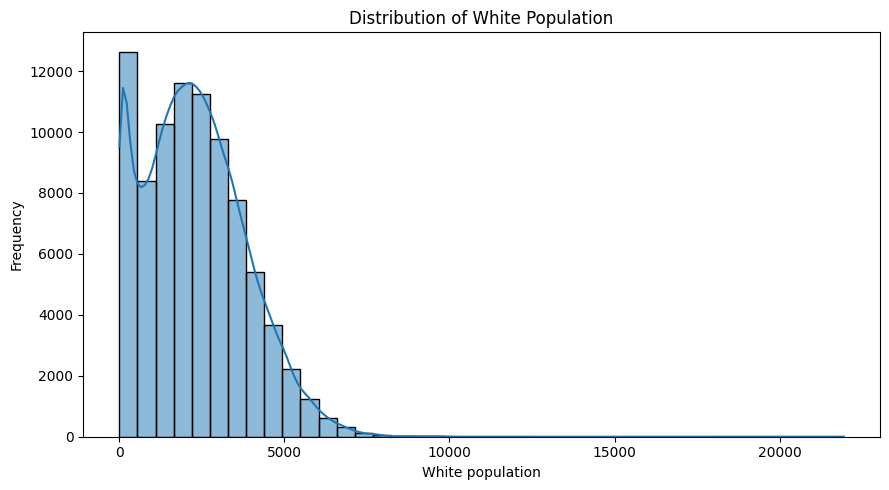

In [ ]:
# Frequency inspection of white population and white share (percentage)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Histogram of raw white_pop counts
plot_df = dp05_df[['white_pop']].dropna()
plt.figure(figsize=(9,5))
sns.histplot(plot_df['white_pop'], bins=40, color='C0', kde = True)
plt.title('Distribution of White Population')
plt.xlabel('White population')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

This Histogram varies from the previous because this is the distribution of the percentage of the white population in terms of the total population. In the histogram below we are able to see that it is mostly left skewed as opposed to the histogram above which is right skewed.

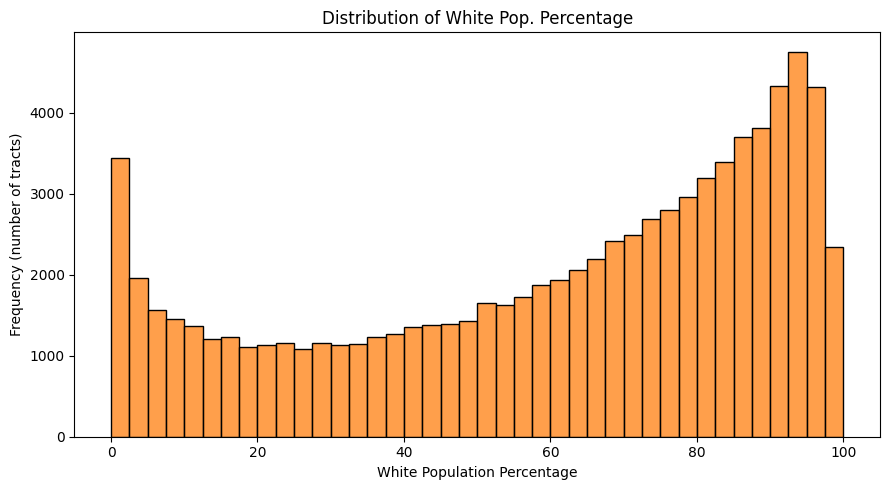

In [ ]:
#Histogram of white share (percentage)
dp05_df['white_share'] = np.where(dp05_df['total_pop'] > 0, dp05_df['white_pop'] / dp05_df['total_pop'], np.nan)
plot_share = dp05_df['white_share'].dropna()
plt.figure(figsize=(9,5))
sns.histplot(plot_share * 100, bins=40, color='C1')  # percent
plt.title('Distribution of White Pop. Percentage')
plt.xlabel('White Population Percentage')
plt.ylabel('Frequency (number of tracts)')
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

Here I am creating the variable high rent burden inside of the dp05 dataframe that was made so that I have the option of looking at it in terms of the dp05 columns.

In [ ]:
# Compare white population and white share by high_rent_burden
dp05_df['high_rent_burden'] = acs_df['percent_income_spent_on_rent'] >= 30

In [ ]:
#Grouped summary statistics
grp = dp05_df.groupby('high_rent_burden').agg(
    count_white_pop=('white_pop','count'),
    mean_white_pop=('white_pop','mean'),
    median_white_pop=('white_pop','median'),
    mean_white_share=('white_share','mean'),
    median_white_share=('white_share', lambda s: np.nanmedian(s.dropna())),
)
print('\nGrouped summary (white_pop / white_share) by high_rent_burden:')
display(grp)


Grouped summary (white_pop / white_share) by high_rent_burden:


,count_white_pop,mean_white_pop,median_white_pop,mean_white_share,median_white_share
high_rent_burden,,,,,
False,48990,2535.459522,2439.5,0.673109,0.753377
True,36405,1979.698613,1795.0,0.509194,0.550451


Here we are able to see a boxplot of the white population percentage by high rent burden. This shows the minimum, maximum, median, first, and third quartile for the white population percentage when they have high rent burden and when they don't. We can use the first, second, and third quartile to see whether or not it is more common for them to suffer, or not suffer from high rent burden. Based on our plot we can see that it is more common for them to not suffer from high rent burden. However, this isn't to say that a large population doesn't suffer.

Again, it is important to note that we are looking at the percentage of the white population in terms of the entire population.

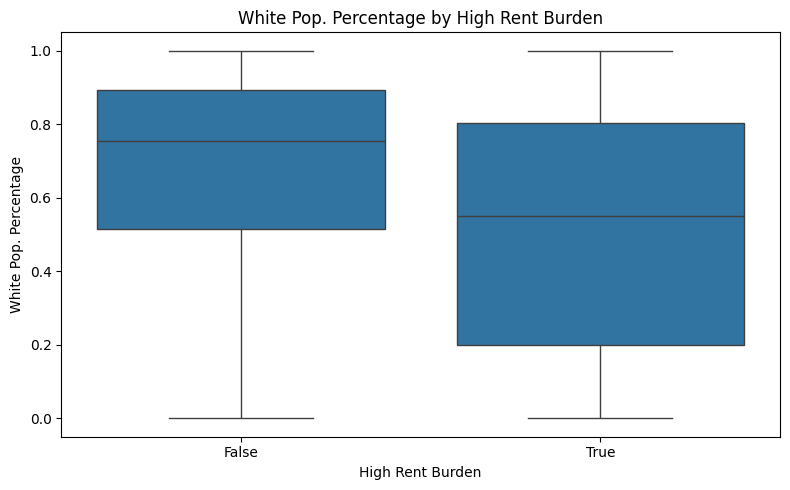

In [ ]:
# Boxplot of white_share by high_rent_burden
plt.figure(figsize=(8,5))
sns.boxplot(x='high_rent_burden', y='white_share', data=dp05_df, showfliers=False)
plt.ylabel('White Pop. Percentage')
plt.xlabel('High Rent Burden')
plt.title('White Pop. Percentage by High Rent Burden')
plt.tight_layout()
plt.show()

I wanted to output the boxplot below because I thought it was interesting to see the difference. In the previous boxplot, the maximum and minimum are the same whereas in the boxplot below the maximums differ. I do find it important to note that both boxplots have a significant overlap which means that they don't differ that much. I do think it is interesting to note that their medians are relatively different.

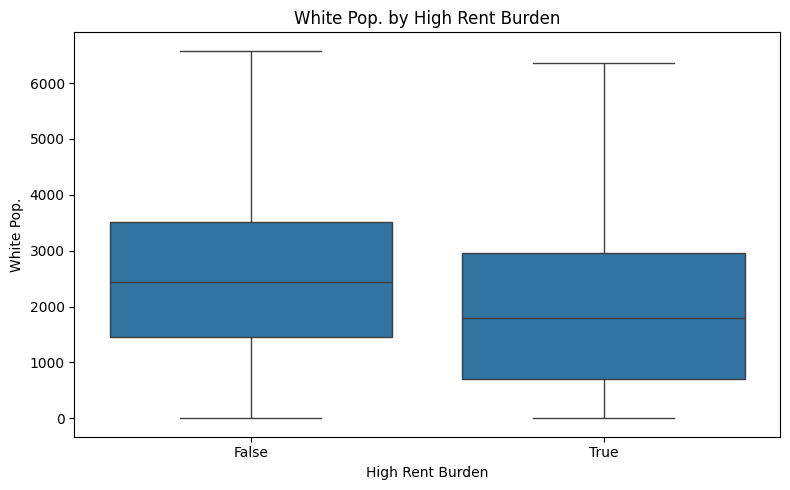

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='high_rent_burden', y='white_pop', data=dp05_df, showfliers=False)
plt.ylabel('White Pop.')
plt.xlabel('High Rent Burden')
plt.title('White Pop. by High Rent Burden')
plt.tight_layout()
plt.show()

A violin of the white population, not the same as the proportion.

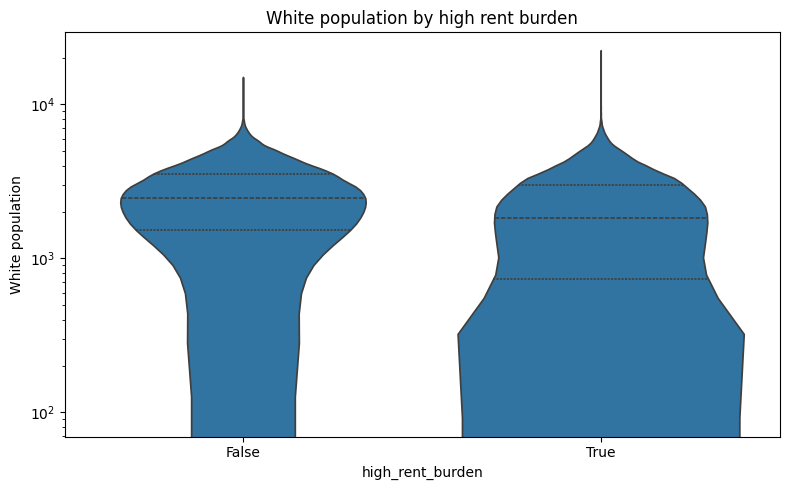

In [ ]:
# Violin (log) of white_popr
plt.figure(figsize=(8,5))
# replace negative/na with small positive for log scaling
dp05_df['white_pop_pos'] = dp05_df['white_pop'].where(dp05_df['white_pop'] > 0, np.nan)

sns.violinplot(x='high_rent_burden', y='white_pop_pos', data=dp05_df.dropna(subset=['white_pop_pos']), inner='quartile')
plt.yscale('log')
plt.ylabel('White population')
plt.title('White population by high rent burden')
plt.tight_layout()
plt.show()


Now we are going to take a look at the hispanic population. We are going to look at the proportion instead of the count.

The snippet of code below is simply creating a variable for the proportion of the hispanic population for when we need it.

In [ ]:
dp05_df['hispanic_share'] = np.where(dp05_df['total_pop'] > 0, dp05_df['hispanic_pop'] / dp05_df['total_pop'], np.nan)

First we look at the distribution of the hispanic population. As we can see, it is right skewed and is significantly less than the white population.

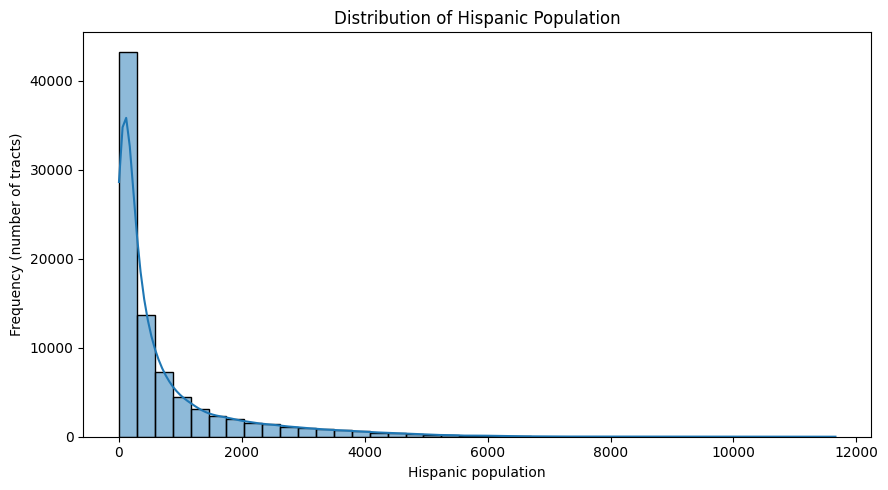

In [ ]:
#looking at the hispanic population in terms of high rent burden
# Frequency inspection of hispanic population and hispanic share
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Histogram of hispanic population
plot_df = dp05_df[['hispanic_pop']].dropna()
plt.figure(figsize=(9,5))
sns.histplot(plot_df['hispanic_pop'], bins=40, color='C0', kde = True)
plt.title('Distribution of Hispanic Population')
plt.xlabel('Hispanic population')
plt.ylabel('Frequency (number of tracts)')
plt.tight_layout()
plt.show()

While technically the hispanic population shows a higher median when it comes to the right box plot (those that do suffer from high rent burden) they are relatively similary. However, we are able to see that the right boxplot has many outliers which means that it is right skewed. The overlap in both of the plots means there isn't much difference between the two groups.

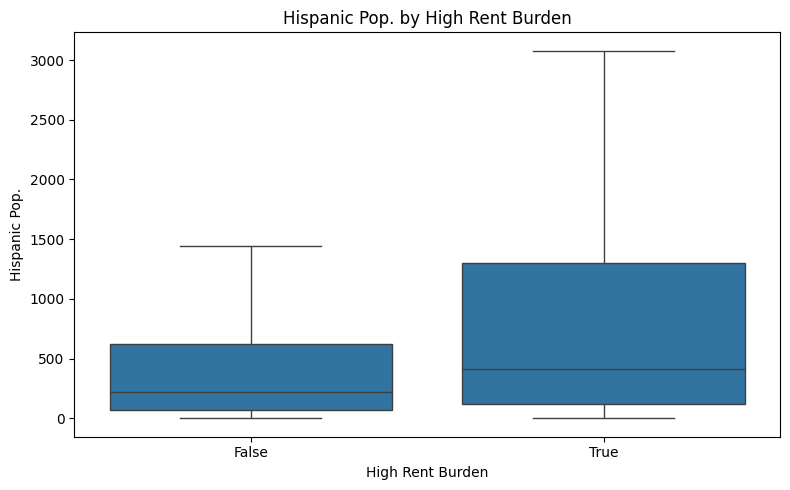

In [ ]:
# Boxplot of hispanic population by high_rent_burden
plt.figure(figsize=(8,5))
sns.boxplot(x='high_rent_burden', y='hispanic_pop', data=dp05_df, showfliers=False)
plt.ylabel('Hispanic Pop.')
plt.xlabel('High Rent Burden')
plt.title('Hispanic Pop. by High Rent Burden')
plt.tight_layout()
plt.show()

Here we simply do what we did with the white population. We turn the hispanic population into a percentage (or a proportion) so that we can look at everything on a scale from 0 - 1. This makes the different tracts comparable even when the populations are different. Especially when a tract has a larger count compared to another one.

This distribution is mostly right skewed and is somewhat different from the previous histogram

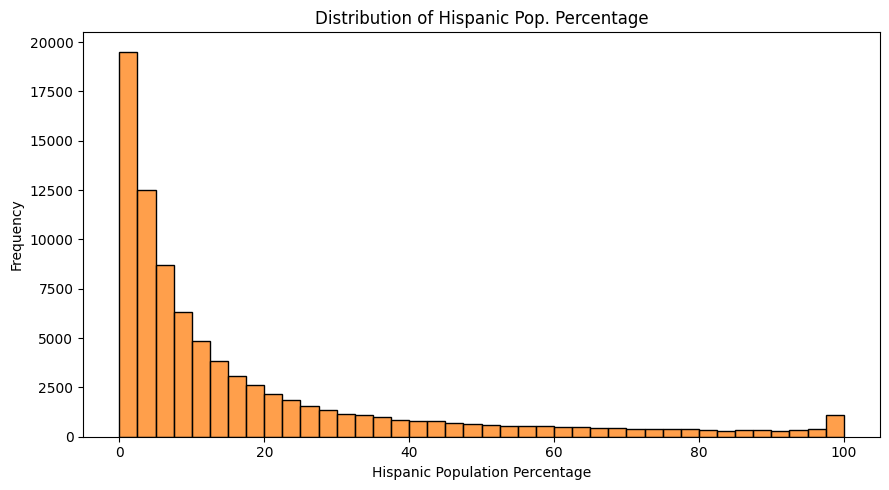

In [ ]:
# Histogram of hisapnic share
plot_share = dp05_df['hispanic_share'].dropna()
plt.figure(figsize=(9,5))
sns.histplot(plot_share * 100, bins=40, color='C1')  # percent
plt.title('Distribution of Hispanic Pop. Percentage')
plt.xlabel('Hispanic Population Percentage')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


Here we are able to see a boxplot that shows hispanic share. While there is significant overlap, the maximum outliers for both boxplots below are signifcantly different. The boxplot on the right has a long upper whisker which indicates that it is right skewed.

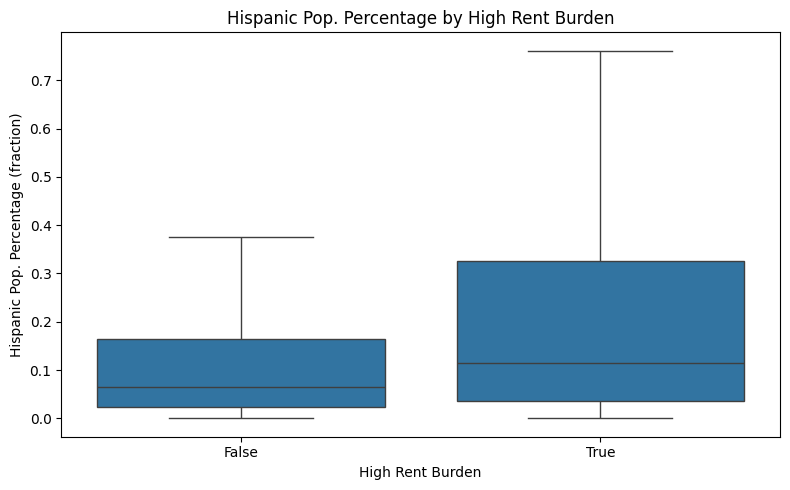

In [ ]:
# Boxplot of hispanic_share by high_rent_burden
plt.figure(figsize=(8,5))
sns.boxplot(x='high_rent_burden', y='hispanic_share', data=dp05_df, showfliers=False)
plt.ylabel('Hispanic Pop. Percentage (fraction)')
plt.xlabel('High Rent Burden')
plt.title('Hispanic Pop. Percentage by High Rent Burden')
plt.tight_layout()
plt.show()

An interesting reference is back to the final notebook where we are able to see that non-white-percentage of the population is high in value on the features list. Below, we are looking at the proportion of the population that is both black and hispanic and whether or not they suffer from high rent burden.

We also need to note that when something says blank including Hispanic it means that it includes Hispanic and non-hispanic within that group. So below we have Black_including_hispanic which takes into consideration the black population that isn't hispanic and the black popoulation that is hispanic. This is because hispanic is treated as an ethnicity which is separate from race.

For the next two features, I will be using the proportion instead of the population count.

Once more, for the black including hispanic population, we are able to see that it is right skewed.

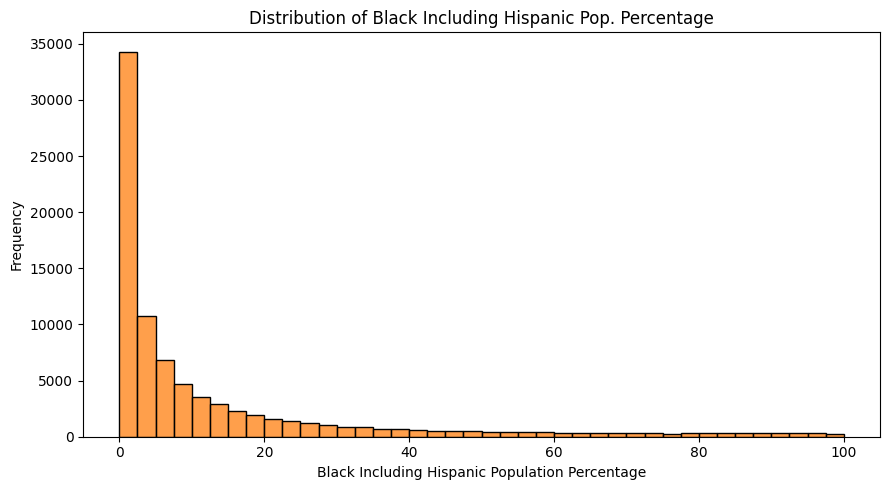

In [ ]:
dp05_df['black_including_hispanic_share'] = np.where(dp05_df['total_pop'] > 0, dp05_df['black_including_hispanic'] / dp05_df['total_pop'], np.nan)
plot_share = dp05_df['black_including_hispanic_share'].dropna()
plt.figure(figsize=(9,5))
sns.histplot(plot_share * 100, bins=40, color='C1')  # percent
plt.title('Distribution of Black Including Hispanic Pop. Percentage')
plt.xlabel('Black Including Hispanic Population Percentage')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()


The boxplots below have a decent amount of overlap and the boxplot on the right (high rent burden being true) has a long upper whisker which indicated that it is right skewed.

However, we are able to see that in general, it is more common for those within the 'black_including_hispanic' population to suffer from high rent burden. However, the averages don't differ that much.

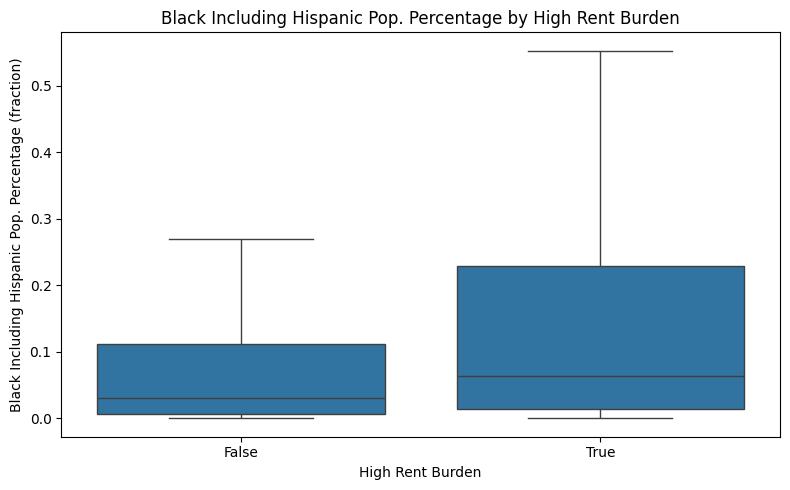

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='high_rent_burden', y='black_including_hispanic_share', data=dp05_df, showfliers=False)
plt.ylabel('Black Including Hispanic Pop. Percentage (fraction)')
plt.xlabel('High Rent Burden')
plt.title('Black Including Hispanic Pop. Percentage by High Rent Burden')
plt.tight_layout()
plt.show()

Here we will look at the proportion of male_25-to_29 in terms of the total population. I want to note that the histograms for the proportion and the count are very different. However, I am sure that if we simply blew up the proportion histogram it would be similiar to the count histogram. However, we are going to look at the proportion when it comes to our heatmap in a just a few moments.

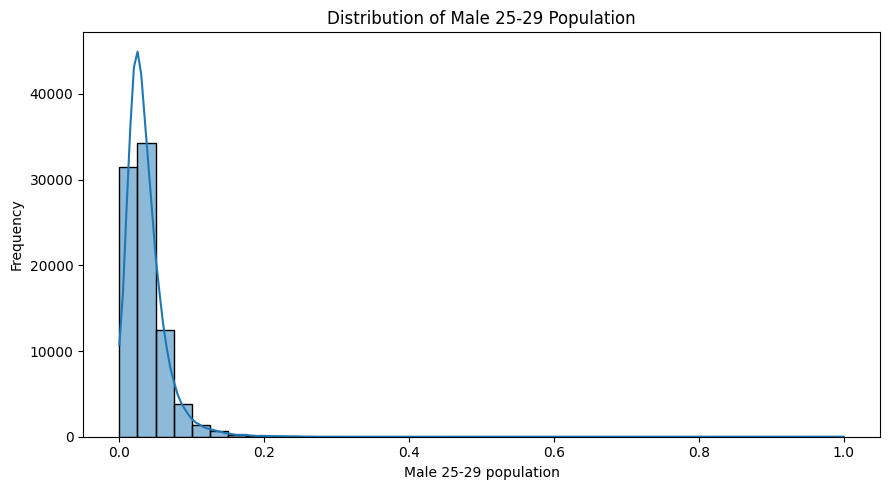

In [ ]:
#Histogram of the male population ages 25-29
dp05_df['male_25_to_29_share'] = np.where(dp05_df['total_pop'] > 0, dp05_df['male_25_to_29'] / dp05_df['total_pop'], np.nan)
plot_df = dp05_df[['male_25_to_29_share']].dropna()
plt.figure(figsize=(9,5))
sns.histplot(plot_df['male_25_to_29_share'], bins=40, color='C0', kde = True)
plt.title('Distribution of Male 25-29 Population')
plt.xlabel('Male 25-29 population')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

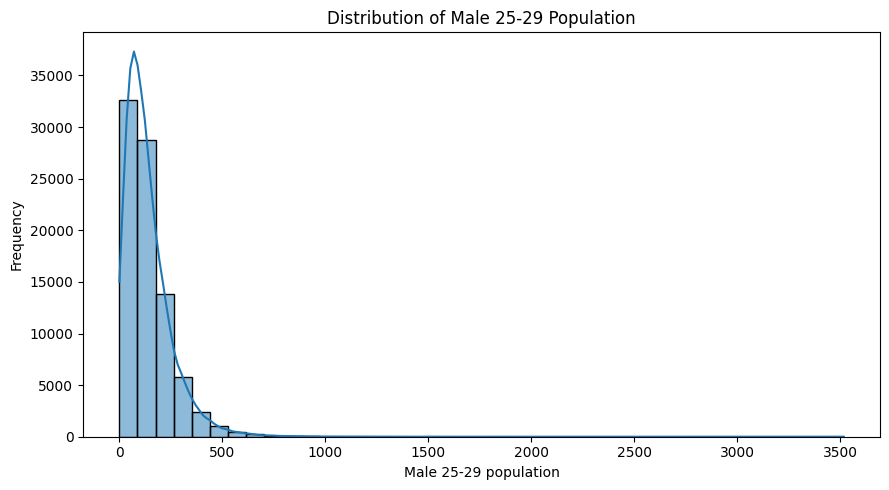

In [ ]:
#Histogram of the male population ages 25-29
plot_df = dp05_df[['male_25_to_29']].dropna()
plt.figure(figsize=(9,5))
sns.histplot(plot_df['male_25_to_29'], bins=40, color='C0', kde = True)
plt.title('Distribution of Male 25-29 Population')
plt.xlabel('Male 25-29 population')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

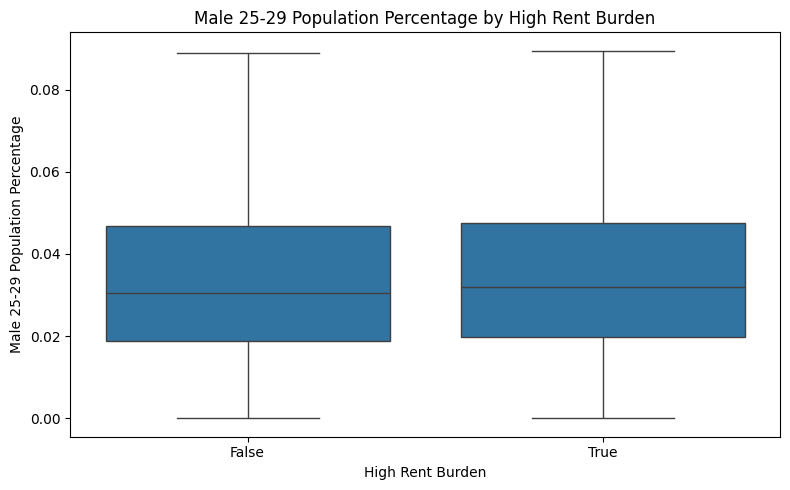

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='high_rent_burden', y='male_25_to_29_share', data=dp05_df, showfliers=False)
plt.ylabel('Male 25-29 Population Percentage')
plt.xlabel('High Rent Burden')
plt.title('Male 25-29 Population Percentage by High Rent Burden')
plt.tight_layout()
plt.show()

In [ ]:
dp05_df['black_share'] = np.where(dp05_df['total_pop'] > 0, dp05_df['black_pop'] / dp05_df['total_pop'], np.nan)

The heatmap below shows the correlation between different proportions within the dp05 dataframe.

- Specifically when it comes to the white and hisapnic proportions, we are able to see that they are strongly negatively correlated. This simply means that tracts with a higher white proportion more often than not have a lower hispanic proportion.

- We are also able to see that the same is true when it comes to the black proportion. Tracts with a higher white proportion tend ot have a lower black proportion.

- We are able to see some strong tradeoffs when it comes to the white proportion vs other races.

- I also want to touch on the redundancy when it comes to black and black_including_hispanic. We are able to see that there is a strong correlation which just means that they are similar. I would drop them but I like being able to visualize how they are similiar because it helps me better understand why that is.

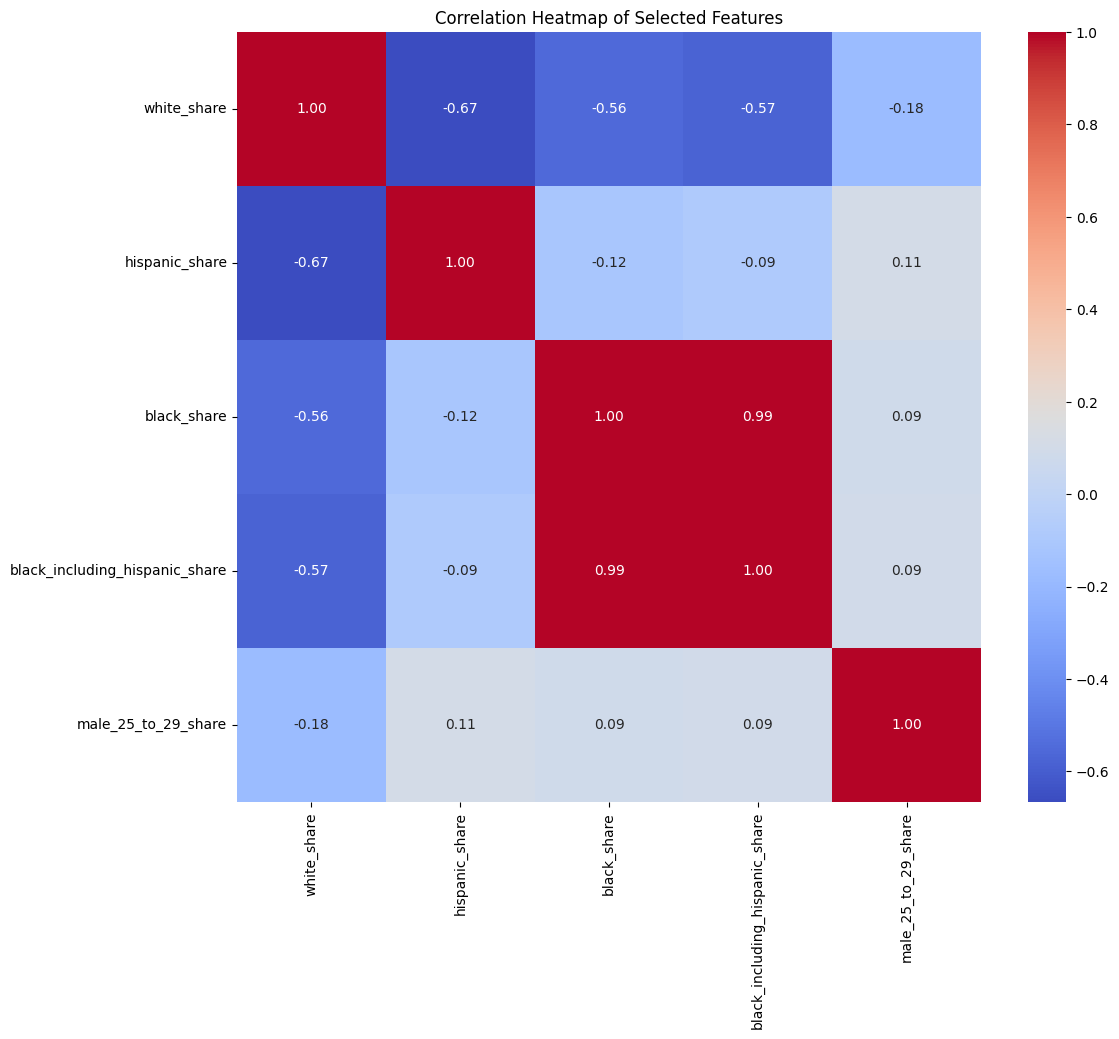

In [ ]:
plt.figure(figsize=(12, 10))
top_cols = ['white_share', 'hispanic_share', 'black_share', 'black_including_hispanic_share', 'male_25_to_29_share']
corr_matrix = dp05_df[top_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

Simply visualizing correlation matric values in a table.

In [ ]:
print(corr_matrix.round(3))

                                white_share  hispanic_share  black_share  \
white_share                           1.000          -0.666       -0.555   
hispanic_share                       -0.666           1.000       -0.118   
black_share                          -0.555          -0.118        1.000   
black_including_hispanic_share       -0.575          -0.086        0.995   
male_25_to_29_share                  -0.179           0.106        0.089   

                                black_including_hispanic_share  \
white_share                                             -0.575   
hispanic_share                                          -0.086   
black_share                                              0.995   
black_including_hispanic_share                           1.000   
male_25_to_29_share                                      0.092   

                                male_25_to_29_share  
white_share                                  -0.179  
hispanic_share                        